# Inertial waves in the disk

\begin{align}
i \omega \vec{u} + \vec{e}_z \times \vec{u} + \nabla p &= 0 \\
i \omega \nabla \cdot \vec{u} + \alpha^2 p &= 0 \\
\left[ \vec{e}_r \cdot \vec{u} \right]_{r = 1} &= 0 \text{ (impenetrable) }
\end{align}

In [1]:
import dedalus_sphere.zernike as Zernike

import numpy as np
import scipy as sp
import scipy.sparse as sparse
from scipy.special import spherical_jn
from scipy.linalg import eig
import matplotlib.pyplot as plt
%matplotlib notebook

np.set_printoptions(precision=3,suppress=True)

dim = 2
D = Zernike.operator(dim, 'D')
E = Zernike.operator(dim, 'E')
Id = Zernike.operator(dim, 'Id')

In [2]:
Nmax, k, m = 250, 0, 1
alpha = 1

In [3]:
def eigsort(A, B, cutoff=np.inf):
    vals, vecs = eig(A, b=B)
    bad = (np.abs(vals) > cutoff)
    vals[bad] = np.nan
    vecs = vecs[:,np.isfinite(vals)]
    vals = vals[np.isfinite(vals)]

    i = np.argsort(vals.real)
    vals, vecs = vals[i], vecs[:, i]

    return vals, vecs


### Tau Method

In [7]:
# Discretize the system
Z = (0*Id)(Nmax,k,m)
bc_plus = Zernike.polynomials(dim,Nmax,k,m+1,1.0)
bc_minus = Zernike.polynomials(dim,Nmax,k,m-1,1.0)

L00 = E(+1)(Nmax, k, m+1)
L01 = Z
L02 = D(+1)(Nmax, k, m)
L11 = -E(+1)(Nmax, k, m-1)
L12 =  D(-1)(Nmax, k, m)
L22 = alpha**2 * E(+1)(Nmax, k, m)

M00 = E(+1)(Nmax, k, m+1)
M11 = E(+1)(Nmax, k, m-1)
M20 = D(-1)(Nmax, k, m+1)
M21 = sparse.vstack([D(+1)(Nmax, k, m-1), np.zeros((1,Nmax))])

# boundary conditions - tau line
L00[-1,:] = bc_plus
L01[-1,:] = bc_minus
L02 = sparse.vstack([L02, np.zeros((1,Nmax))])
M00[-1,:] = 0

L = sparse.bmat([[L00,L01,L02],[Z,L11,L12],[Z,Z,L22]])
M = -sparse.bmat([[M00,Z,Z],[Z,M11,Z],[M20,M21,Z]])

evalues_tau, evectors_tau = eigsort(L.todense(), M.todense())

/opt/miniconda3/envs/dedalus/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Galerkin

In [11]:
# Discretize the system
Z = (0*Id)(Nmax,k,m)

L00 =  (E(+1) @ E(-1))(Nmax, k+1, m+1)[:Nmax,:]
L02 =  D(+1)(Nmax, k, m)
L11 = -(E(+1) @ E(-1))(Nmax, k+1, m-1)[:Nmax,:]
L12 =  D(-1)(Nmax, k, m)
L22 = alpha**2 * E(+1)(Nmax, k, m)[:Nmax,:]

L02 = sparse.vstack([L02, np.zeros(Nmax)])

M00 = (E(+1) @ E(-1))(Nmax, k+1, m+1)[:Nmax,:]
M11 = (E(+1) @ E(-1))(Nmax, k+1, m-1)[:Nmax,:]
M20 = (D(-1) @ E(-1))(Nmax, k+1, m+1)[:Nmax,:]
M21 = (D(+1) @ E(-1))(Nmax, k+1, m-1)

L = sparse.bmat([[L00,Z,L02],[Z,L11,L12],[Z,Z,L22]])
M = -sparse.bmat([[M00,Z,Z],[Z,M11,Z],[M20,M21,Z]])

evalues_galerkin, evectors_galerkin = eigsort(L.todense(), M.todense())

(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)


<IPython.core.display.Javascript object>


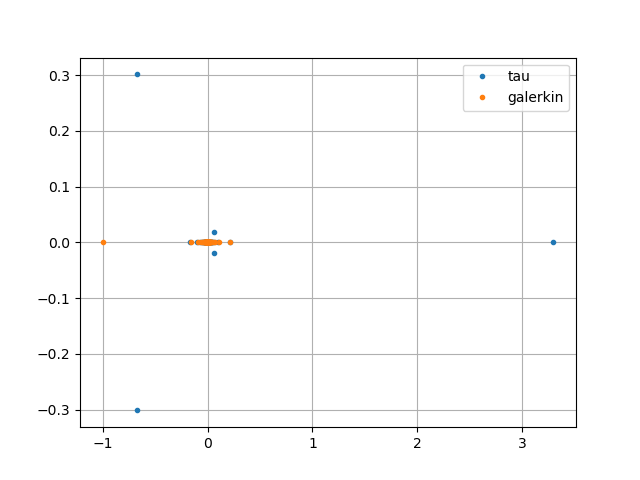

In [12]:
plt.figure()
plt.plot(evalues_tau.real, evalues_tau.imag, '.', label='tau')
plt.plot(evalues_galerkin.real, evalues_galerkin.imag, '.', label='galerkin')
plt.legend()
plt.grid()
